In [167]:
import pandas as pd
import geopandas as gpd
import seaborn as sns
import matplotlib.pyplot as plt
from zipfile import ZipFile
import os

In [168]:
# Define a function to calculate the percentage of missing dates for each station
def calculate_missing_percentage(df):
    total_dates = len(df)
    missing_dates = df.isnull().sum()
    missing_percentage = (missing_dates / total_dates) * 100
    return missing_percentage

In [169]:
# Define data paths and file names
data_path = r"../GeoData_WS2023_2_Final_D/data/original"
station_file_name = '/KL_Jahreswerte_Beschreibung_Stationen.txt'
full_fname = data_path + station_file_name

In [170]:
# Read station metadata
headers = open(full_fname).readline().split()
df_stat = pd.read_fwf(full_fname,
                      encoding="cp1252",
                      skiprows=2,
                      names=headers,
                      index_col="Stations_id", 
                      parse_dates=["von_datum","bis_datum"])

In [171]:
# Filter stations by criteria
idx_BY = df_stat["Bundesland"] == "Bayern"
idx_active = df_stat["bis_datum"] > "2022-12-31"
idx_early = df_stat["von_datum"] < "1950"
df_stat_short = df_stat[idx_BY & idx_active & idx_early]

In [172]:
# Get list of file names from directory
fname_list = os.listdir('../GeoData_WS2023_2_Final_D/data/original')
f_dict = {}

In [173]:
# Create a dictionary with station ID as keys and file names as values
for fname in fname_list:
    split_fname = fname.split("_")
    if len(split_fname) > 2:
        key = split_fname[2]
        try:
            station_id = int(key)
            f_dict[station_id] = fname
        except ValueError:
            print(f"Skipping '{fname}' as it does not contain a valid station ID.")
    else:
        print(f"Skipping '{fname}' as it does not represent a temperature data file.")

Skipping 'DWD' as it does not represent a temperature data file.
Skipping 'KL_Jahreswerte_Beschreibung_Stationen.txt' as it does not contain a valid station ID.


In [174]:
zip_list = [data_path + '/' + f_dict[k] for k in df_stat_short.index if k in f_dict]

In [175]:
# Define the period of interest
date_from = pd.Timestamp('1950-01-01')
date_to = pd.Timestamp('2022-12-31')

In [176]:
# Define a function to read temperature data from zip files and merge into a DataFrame
def read_temperature_data(zip_list, date_from, date_to):
    # Initialize an empty DataFrame.
    df = pd.DataFrame()
    
    # Iterate over each element in zip_list.
    for elt in zip_list:
        try:
            # Open the zip file.
            with ZipFile(elt) as myzip:
                # Find the first file in the zip file whose name starts with "produkt".
                prodfilename = [name for name in myzip.namelist() if name.split("_")[0]=="produkt"][0]
                
                # Open the "produkt" file and read it into a DataFrame.
                with myzip.open(prodfilename) as myfile:
                    dftmp = pd.read_csv(myfile, sep=";", parse_dates=["MESS_DATUM_BEGINN", "MESS_DATUM_ENDE"], 
                                        index_col="MESS_DATUM_BEGINN", na_values=-999.0)
                    
                    # Select the period of interest
                    dftmp = dftmp[(dftmp.index >= date_from) & (dftmp.index <= date_to)]
                    
                    # Select the "JA_TT" column, rename the series with the station ID, and convert it to a DataFrame.
                    s = dftmp["JA_TT"].rename(dftmp["STATIONS_ID"].iloc[0]).to_frame()
                    
                    # Merge the new DataFrame into the main DataFrame using an outer join on the index.
                    df = pd.merge(df, s, left_index=True, right_index=True, how='outer')
        except FileNotFoundError:
            print(f"The file '{elt}' does not exist.")
        except KeyError:
            print(f"The file '{prodfilename}' does not contain the expected columns.")
        except Exception as e:
            print(f"An unexpected error occurred: {e}")
    
    # Rename the index of the DataFrame.
    df.index.rename(name="year", inplace=True)
    
    return df

In [177]:
df_temp = read_temperature_data(zip_list, date_from, date_to)

In [178]:
missing_percentages = calculate_missing_percentage(df_temp)

In [179]:
filtered_stations = missing_percentages[missing_percentages <= 5].index
df_temp_filtered = df_temp[filtered_stations]

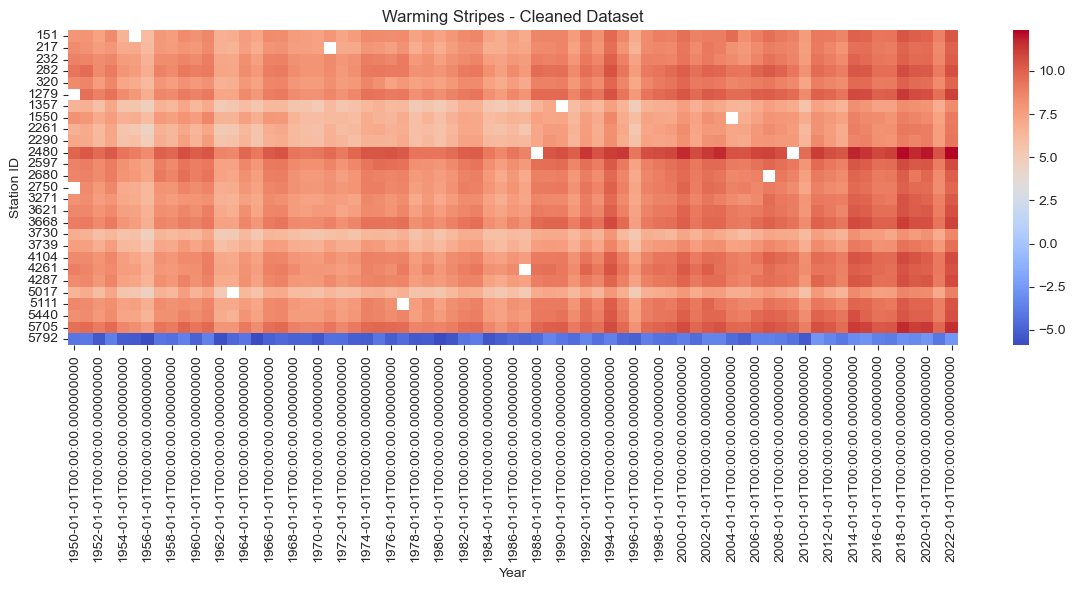

In [180]:
if not df_temp_filtered.empty:
    sns.set_style('ticks')
    fig, ax = plt.subplots(figsize=(12, 6))
    sns.heatmap(df_temp_filtered.T, cmap='coolwarm', ax=ax)
    plt.title('Warming Stripes - Cleaned Dataset')
    plt.xlabel('Year')
    plt.ylabel('Station ID')
    plt.tight_layout()
    plt.show()
else:
    print("No data available after filtering.")

In [181]:
gdf_stations = gpd.GeoDataFrame(df_stat_short, 
                                 geometry=gpd.points_from_xy(df_stat_short['geoLaenge'], df_stat_short['geoBreite']),
                                 crs='EPSG:4326')
gdf_filtered_stations = gdf_stations.loc[filtered_stations]
gdf_filtered_stations.to_file('filtered_stations.gpkg', layer='filtered_stations', driver='GPKG')

In [194]:
import pandas as pd
from scipy.interpolate import griddata

In [195]:
df_without_4104 = df_temp_filtered[df_temp_filtered.columns.difference([4104])]

In [196]:
points = df_stat_short.loc[df_without_4104.columns][['geoBreite', 'geoLaenge']].values

In [197]:
values = df_without_4104.mean().values

In [198]:
point = df_stat_short.loc[4104][['geoBreite', 'geoLaenge']].values.reshape(1,-1)

In [199]:
temp_4104 = griddata(points, values, point, method='cubic')

In [200]:
actual_temp_4104 = df_temp_filtered[4104].mean()
error = actual_temp_4104 - temp_4104

In [201]:
print(f'The error of the interpolation is {error}')

The error of the interpolation is [0.04030211]


In [203]:
import matplotlib.pyplot as plt

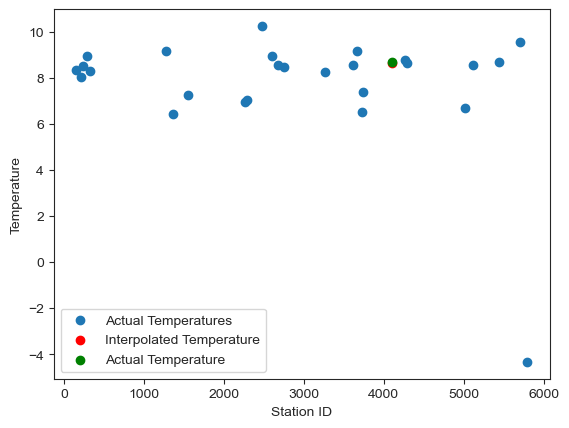

In [205]:
# Get station IDs for which we have temperature data
station_ids = df_without_4104.columns

# Get corresponding actual temperatures
actual_temps = df_temp_filtered[station_ids].mean().values

# Create a scatter plot of the actual temperatures
plt.scatter(station_ids, actual_temps, label='Actual Temperatures')

# Highlight the interpolated temperature of Station 4104
plt.scatter(4104, temp_4104, color='red', label='Interpolated Temperature')

# Highlight the actual temperature of Station 4104
plt.scatter(4104, actual_temp_4104, color='green', label='Actual Temperature')

# Add labels and legend
plt.xlabel('Station ID')
plt.ylabel('Temperature')
plt.legend()

# Show the plot
plt.show()

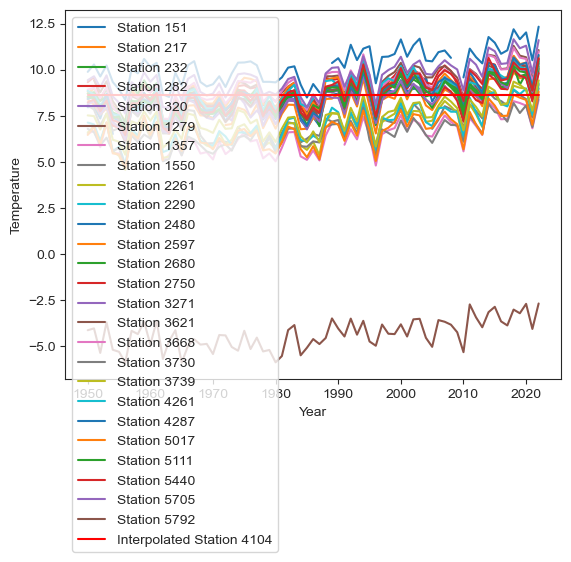

In [210]:
import matplotlib.pyplot as plt

# Plot the temperature for each station
for station in df_without_4104.columns:
    plt.plot(df_without_4104.index, df_without_4104[station], label=f'Station {station}')

# Plot the interpolated temperature for Station 4104
plt.plot(df_temp_filtered.index, [temp_4104]*len(df_temp_filtered), color='red', label='Interpolated Station 4104')

# Add labels and legend
plt.xlabel('Year')
plt.ylabel('Temperature')
plt.legend()

# Show the plot
plt.show()

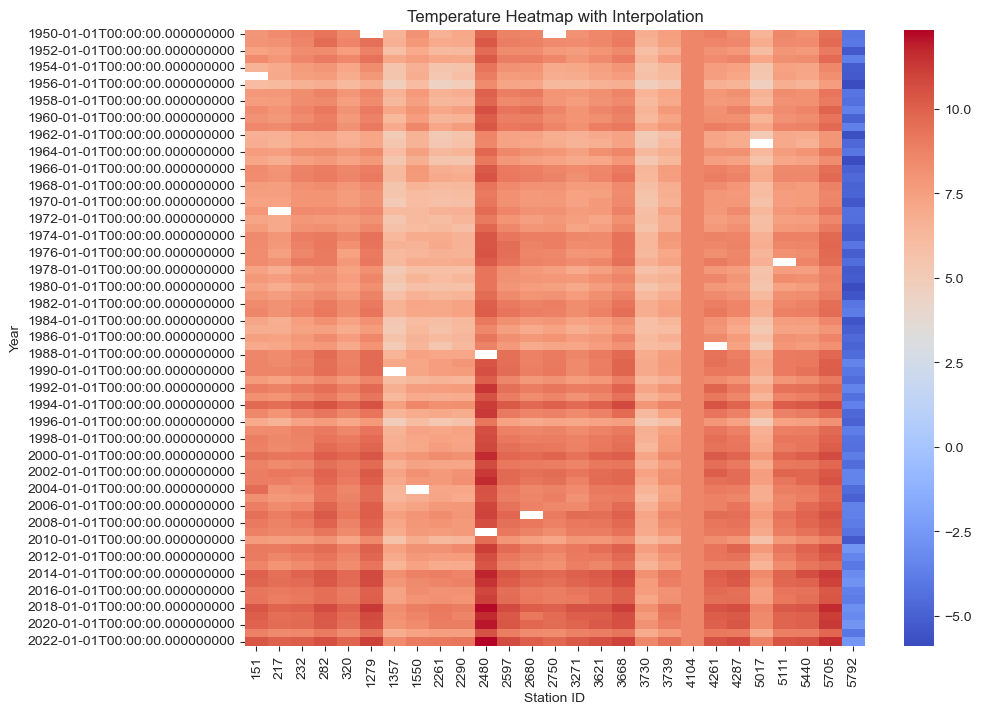

In [214]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Create a pandas Series of the same length as the DataFrame, filled with the interpolated temperature
temp_4104_series = pd.Series([temp_4104[0]] * len(df_temp_filtered), index=df_temp_filtered.index)

# Add the interpolated temperature for Station 4104 to the DataFrame
df_temp_filtered.loc[:, 4104] = temp_4104_series

# Create a heatmap of the temperatures
plt.figure(figsize=(10, 8))
sns.heatmap(df_temp_filtered, cmap='coolwarm')

# Add labels
plt.xlabel('Station ID')
plt.ylabel('Year')
plt.title('Temperature Heatmap with Interpolation')

# Show the plot
plt.show()

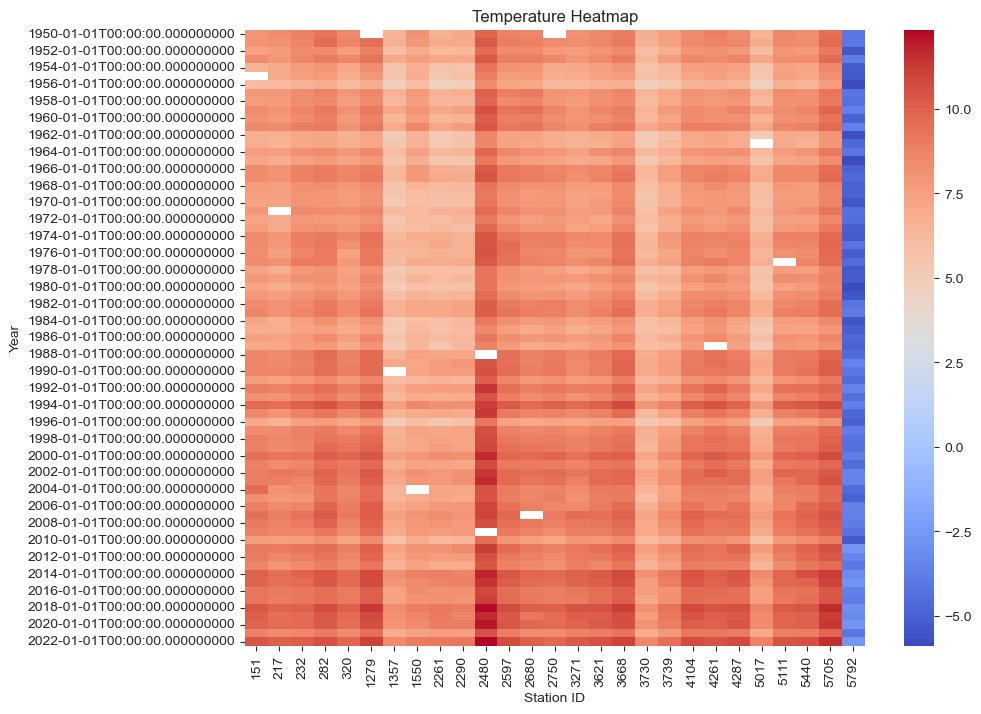

In [211]:
import seaborn as sns

# Create a heatmap of the temperatures
plt.figure(figsize=(10, 8))
sns.heatmap(df_temp_filtered, cmap='coolwarm')

# Add labels
plt.xlabel('Station ID')
plt.ylabel('Year')
plt.title('Temperature Heatmap')

# Show the plot
plt.show()